In [1]:

import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_evaluation as utils_eval
import ast


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)


In [2]:
eval_dir = "../../data-misc/evaluations"

l1_dirs = ["Scratch-Pretrained-FineTuned"]  # winner
l2_dirs = ["predict_cmb_valid", "predict_cmb_dou", "predict_cmb_crb"]
l3_dirs = ["valloss"]

(
    df_classification,
    df_detection,
    df_segmentation,
    detection_details,
    segmentation_details,
    cmb_results,
) = utils_eval.load_evaluation_data(
    eval_dir, l1_dirs, l2_dirs, l3_dirs
)

In [3]:
# Flatten the data into a list
flattened_data = []
for key, entries in detection_details.items():
    if not entries:
        continue
    for entry in entries:
        # Combine key tuple and entry dictionary
        combined_entry = dict(zip(['Model', 'Dataset', 'Criteria', 'Location'], key))
        combined_entry.update(entry)
        flattened_data.append(combined_entry)

# Create a DataFrame
df_detection_serieslevel = pd.DataFrame(flattened_data)


In [4]:
gt_radiomics_metadata_csv = (
    "../../data-misc/csv/CMB_radiomics_metadata.csv"
)
gt_cmb_metadata_csv = (
    "../..//data-misc/csv/CMB_metadata_all.csv"
)
all_studies_csv = "../../data-misc/csv/ALL_studies.csv"

all_studies_df = pd.read_csv(all_studies_csv)
GT_metadata = pd.read_csv(gt_cmb_metadata_csv)
GT_metadata_radiomics = pd.read_csv(gt_radiomics_metadata_csv)

# Convert string representations of tuples to actual tuples
GT_metadata["CM"] = GT_metadata["CM"].apply(lambda x: tuple(ast.literal_eval(x)))
GT_metadata_radiomics["CM"] = GT_metadata_radiomics["CM"].apply(
    lambda x: tuple(ast.literal_eval(x))
)

GT_metadata_all = pd.merge(
    GT_metadata, GT_metadata_radiomics, on=["seriesUID", "CM"], how="inner"
).drop(
    columns=[
        "firstorder_10Percentile",
        "firstorder_90Percentile",
        "firstorder_Energy",
        "firstorder_Entropy",
        "firstorder_InterquartileRange",
        "firstorder_Kurtosis",
        "firstorder_Maximum",
        "firstorder_MeanAbsoluteDeviation",
        "firstorder_Mean",
        "firstorder_Median",
        "firstorder_Minimum",
        "firstorder_Range",
        "firstorder_RobustMeanAbsoluteDeviation",
        "firstorder_RootMeanSquared",
        "firstorder_Skewness",
        "firstorder_TotalEnergy",
        "firstorder_Uniformity",
        "firstorder_Variance",
    ]
)
valid_studies  =os.listdir("/storage/evo1/jorge/datasets/cmb/cmb_valid/Data")

/tmp/ipykernel_3348268/3006505715.py:10: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  GT_metadata = pd.read_csv(gt_cmb_metadata_csv)


# Undestand data better

In [5]:
all_studies_testing = all_studies_df[(all_studies_df["seriesUID"].isin(valid_studies)) | (all_studies_df["Dataset"].isin(['DOU', 'CRB']))]

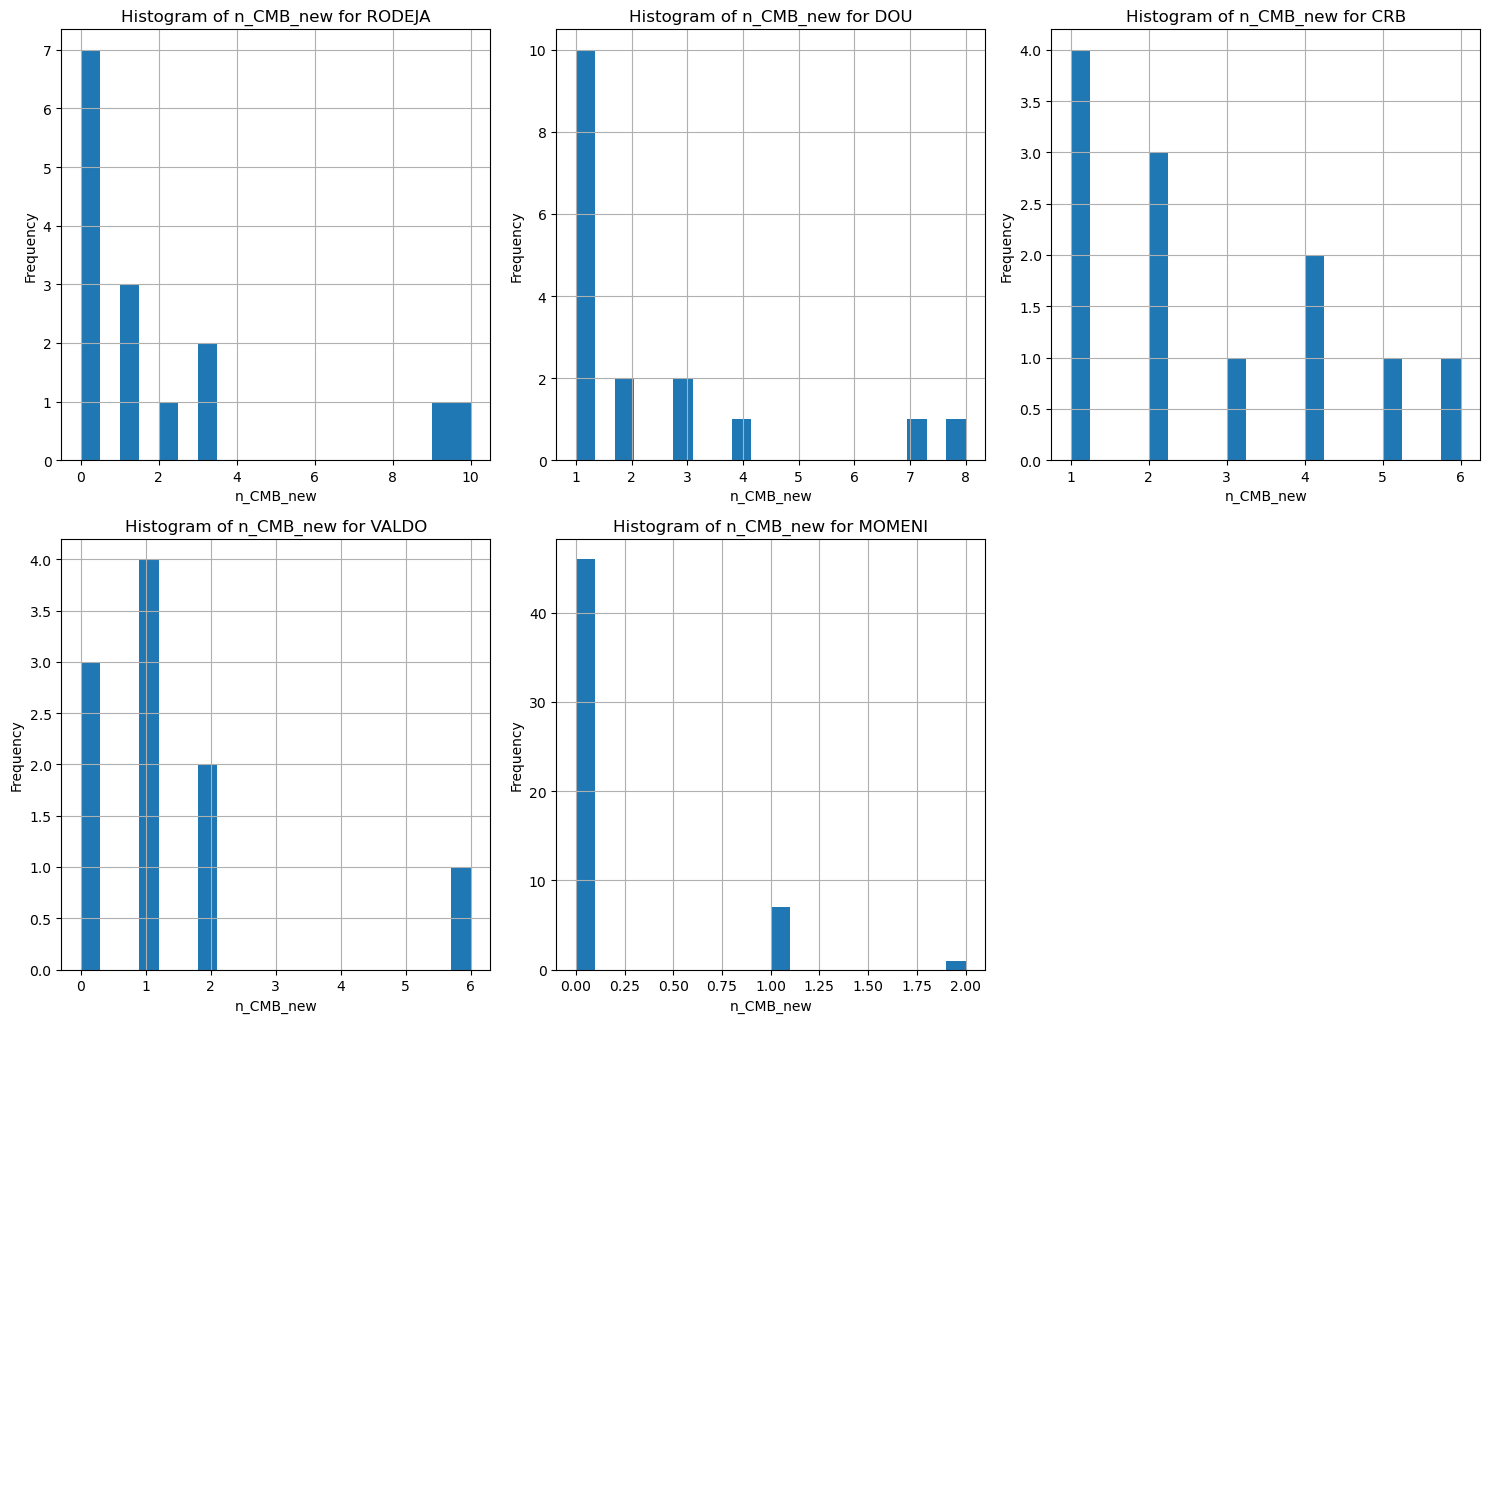

In [6]:
import matplotlib.pyplot as plt

# Filter the DataFrame
filtered_data = all_studies_testing[all_studies_testing['n_CMB_new'] <= 10]

# Get unique datasets
unique_datasets = filtered_data['Dataset'].unique()

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes to simplify the loop

# Loop through the datasets and plot histograms in each subplot
for i, dataset in enumerate(unique_datasets):
    ax = axs[i]  # Select the corresponding subplot
    data_subset = filtered_data[filtered_data['Dataset'] == dataset]
    data_subset['n_CMB_new'].hist(bins=20, ax=ax)
    ax.set_title(f'Histogram of n_CMB_new for {dataset}')
    ax.set_xlabel('n_CMB_new')
    ax.set_ylabel('Frequency')

# If there are more subplots than datasets, turn off the extra subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### undestand count groups

In [7]:
import pandas as pd

# Define the bins and labels for the groupings
bins = [0, 3, 5, 11, float('inf')]  # Upper limit is infinity to include all possible higher values
labels = ['1-3', '4-5', '6-11', '12+']

# Create a new column for the grouped data
all_studies_testing['Group'] = pd.cut(all_studies_testing['n_CMB_new'], bins=bins, labels=labels, right=False)

# Group by 'Dataset' and 'Group', then count the occurrences
grouped_counts = all_studies_testing.groupby(['Dataset', 'Group']).size().unstack(fill_value=0)

# Print the result
print(grouped_counts)


Group    1-3  4-5  6-11  12+
Dataset                     
CRB        7    3     2    6
DOU       12    3     2    3
MOMENI    54    0     0    2
RODEJA    11    2     2    1
VALDO      9    0     1    0


/tmp/ipykernel_3348268/1164852056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_studies_testing['Group'] = pd.cut(all_studies_testing['n_CMB_new'], bins=bins, labels=labels, right=False)
/tmp/ipykernel_3348268/1164852056.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = all_studies_testing.groupby(['Dataset', 'Group']).size().unstack(fill_value=0)


In [8]:
import pandas as pd

# Assuming all_studies_testing is already defined and loaded
# Define thresholds and create binary columns
thresholds = [3, 5, 11]
for threshold in thresholds:
    column_name = f'Above_{threshold-1}'
    all_studies_testing[column_name] = (all_studies_testing['n_CMB_new'] >= threshold).astype(int)

# Group by 'Dataset' and sum to count how many entries are above each threshold by dataset
grouped_counts_binary = all_studies_testing.groupby('Dataset')[[f"Above_{t-1}" for t in thresholds ]].sum()

# Print the result
print(grouped_counts_binary)

all_studies_testing.groupby('Dataset').count()

         Above_2  Above_4  Above_10
Dataset                            
CRB           11        8         6
DOU            8        5         3
MOMENI         2        2         2
RODEJA         5        3         1
VALDO          1        1         0


/tmp/ipykernel_3348268/2711011827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_studies_testing[column_name] = (all_studies_testing['n_CMB_new'] >= threshold).astype(int)
/tmp/ipykernel_3348268/2711011827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_studies_testing[column_name] = (all_studies_testing['n_CMB_new'] >= threshold).astype(int)
/tmp/ipykernel_3348268/2711011827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,seriesUID,series,n_CMB_new,seq_type,res_level,healthy,healthy_all,field_strength,TE,subject,patientUID,n_CMB_old,old_shape,new_shape,old_voxel_dim,new_voxel_dim,old_orientation,new_orientation,studyUID_old,n_indataset,newCMB,diffCMB,nCMB_avg,CMB_level,Group,Above_2,Above_4,Above_10
Dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CRB,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
DOU,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
MOMENI,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,16,56,56,56,56
RODEJA,16,16,16,16,16,16,16,16,0,16,16,16,16,16,16,16,16,16,16,16,16,16,16,9,16,16,16,16
VALDO,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,10,10,10,10


# Re-computed macro and micro

In [9]:
print(
    df_detection_serieslevel["Model"].unique(),
    df_detection_serieslevel["Criteria"].unique(),
)
print(
    df_detection_serieslevel.columns
)

['Scratch-Pretrained-FineTuned'] ['valloss']
Index(['Model', 'Dataset', 'Criteria', 'seriesUID', 'Precision', 'Recall',
       'F1', 'FPavg', 'FPcmb', 'TP', 'FP', 'FN', 'n_true_cmb', 'n_pred_cmb'],
      dtype='object')


In [10]:
aggregations = {
    'Precision': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std', 'count'],
    'F1': ['mean', 'std', 'count'],
    'FPavg': ['mean', 'std', 'count'],
    'FPcmb': ['mean', 'std', 'count'],
    'TP': ['sum', 'mean'],
    'FP': ['sum', 'mean'],
    'FN': ['sum', 'mean'],
    'n_true_cmb': ['sum'],
    'n_pred_cmb': ['sum'],
}

## Number of microbleeds per scan

In [11]:
df_detection_serieslevel = pd.merge(df_detection_serieslevel, all_studies_testing[['seriesUID', 'n_CMB_new']], on=["seriesUID"], how="left")

In [12]:
df_detection_serieslevel

,Model,Dataset,Criteria,seriesUID,Precision,Recall,F1,FPavg,FPcmb,TP,FP,FN,n_true_cmb,n_pred_cmb,n_CMB_new
0,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00001-CMB-2,NaN,0.000000,NaN,0.0,0.0,0,0,2,2,0,2
1,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00008-CMB-1,0.500000,1.000000,0.666667,1.0,1.0,1,1,0,1,2,1
2,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00051-CMB-3,1.000000,0.666667,0.800000,0.0,0.0,2,0,1,3,2,3
3,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00070-CMB-10,0.888889,0.800000,0.842105,1.0,0.1,8,1,2,10,9,10
4,Scratch-Pretrained-FineTuned,valid,valloss,RODEJA-00095-H,0.000000,NaN,NaN,1.0,NaN,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082104124198400000049-CMB-2,NaN,0.000000,NaN,0.0,0.0,0,0,2,2,0,2
74,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000001-CMB-5,1.000000,0.400000,0.571429,0.0,0.0,2,0,3,5,2,5
75,Scratch-Pretrained-FineTuned,crb,valloss,CRB-1.3.12.2.1107.5.2.6.24111.30000019082703511493700000040-CMB-11,1.000000,0.090909,0.166667,0.0,0.0,1,0,10,11,1,11
76,Scratch-Pretrained-FineTuned,crb,valloss,CRB-42a2a5865709f9ddc47da60a1556f09552586685-CMB-6,1.000000,0.166667,0.285714,0.0,0.0,1,0,5,6,1,6


In [13]:
df_detection_serieslevel['>10cmb'] = df_detection_serieslevel['n_CMB_new'].apply(lambda x: "yes" if x  >= 10 else "no")

In [14]:
filtered_data = all_studies_testing

studies_normal_count = filtered_data['seriesUID']

# Macro
df_detection_serieslevel_normalcount = df_detection_serieslevel[df_detection_serieslevel['seriesUID'].isin(studies_normal_count)]
print(
    f"Filtered data from {len(df_detection_serieslevel)} to {len(df_detection_serieslevel_normalcount)}"
)
df_detection_serieslevel_macro = df_detection_serieslevel_normalcount.groupby(['Dataset', ">10cmb"]).agg(aggregations).round(2)

# F1*
df_detection_serieslevel_macro['F1*'] = 2 * (df_detection_serieslevel_macro['Precision']['mean'] * df_detection_serieslevel_macro['Recall']['mean']) / (df_detection_serieslevel_macro['Precision']['mean'] + df_detection_serieslevel_macro['Recall']['mean'])


# Micro
global_cm = df_detection_serieslevel_normalcount.groupby(['Dataset', ">10cmb"]).agg(
 {
    'TP': ['sum'],
    'FP': ['sum'],
    'FN': ['sum'],
    'seriesUID': ['count'],
}   
    
    ).round(2)
global_cm.reset_index(inplace=True)
global_cm.columns = global_cm.columns.droplevel(1)
df_detection_serieslevel_micro = global_cm.copy()
df_detection_serieslevel_micro['Precision'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FP'])
df_detection_serieslevel_micro['Recall'] = df_detection_serieslevel_micro['TP'] / (df_detection_serieslevel_micro['TP'] + df_detection_serieslevel_micro['FN'])
df_detection_serieslevel_micro['F1'] = 2 * (df_detection_serieslevel_micro['Precision'] * df_detection_serieslevel_micro['Recall']) / (df_detection_serieslevel_micro['Precision'] + df_detection_serieslevel_micro['Recall'])
df_detection_serieslevel_micro['FPavg'] = df_detection_serieslevel_micro['FP'] / df_detection_serieslevel_micro['seriesUID']
df_detection_serieslevel_micro


Filtered data from 78 to 78


,Dataset,>10cmb,TP,FP,FN,seriesUID,Precision,Recall,F1,FPavg
0,crb,no,12,8,20,12,0.600000,0.375000,0.461538,0.666667
1,crb,yes,26,8,69,6,0.764706,0.273684,0.403101,1.333333
2,dou,no,31,3,8,17,0.911765,0.794872,0.849315,0.176471
3,dou,yes,20,7,15,3,0.740741,0.571429,0.645161,2.333333
4,valid,no,34,56,9,36,0.377778,0.790698,0.511278,1.555556
5,valid,yes,37,12,17,4,0.755102,0.685185,0.718447,3.000000


In [15]:
df_detection_serieslevel_macro

Precision             Recall                F1              \
                    mean   std count   mean   std count  mean   std count   
Dataset >10cmb                                                              
crb     no          0.76  0.31     9   0.41  0.36    12  0.51  0.15     9   
        yes         0.81  0.15     6   0.21  0.19     6  0.30  0.19     6   
dou     no          0.93  0.19    15   0.83  0.35    17  0.92  0.16    15   
        yes         0.81  0.18     3   0.56  0.18     3  0.63  0.09     3   
valid   no          0.47  0.46    35   0.83  0.33    22  0.82  0.22    20   
        yes         0.81  0.18     4   0.69  0.10     4  0.74  0.11     4   

               FPavg             FPcmb              TP        FP        FN  \
                mean   std count  mean   std count sum  mean sum  mean sum   
Dataset >10cmb                                                               
crb     no      0.67  1.23    12  0.50  1.15    12  12  1.00   8  0.67  20   
        yes     1.33  1.86     6  0.06  0.06     6  26  4.33   8  1.33  69   
dou     no      0.18  0.53    17  0.15  0.49    17  31  1.82   3  0.18   8   
        yes     2.33  2.52     3  0.19  0.19     3  20  6.67   7  2.33  15   
valid   no      1.56  2.77    36  0.47  0.81    22  34  0.94  56  1.56   9   
        yes     3.00  3.16     4  0.19  0.18     4  37  9.25  12  3.00  17   

                      n_true_cmb n_pred_cmb       F1*  
                 mean        sum        sum            
Dataset >10cmb                                         
crb     no       1.67         32         20  0.532650  
        yes     11.50         95         35  0.333529  
dou     no       0.47         39         34  0.877159  
        yes      5.00         35         28  0.662190  
valid   no       0.25         43         90  0.600154  
        yes      4.25         54         49  0.745200

In [19]:
df_detection_serieslevel.groupby(['Dataset', ">10cmb"]).size()

Dataset  >10cmb
crb      no        12
         yes        6
dou      no        17
         yes        3
valid    no        36
         yes        4
dtype: int64